### Introduction
The Ecommerce Dataset has information about 100k purchases (orders) from 2016 to 2018. Prices are converted from Brazillian Real (BRL) to EUR using a rough 0.25 conversoin rate. And there are five tables in this dataset: payments, geolocation, customers, orders and classifications. The last one contains votes from three different analysts for around 3k reviews made by customers after they've received their products (through email satisfaction survey).

This notebook will go through 4 tables with a quick analysis:

* Payments
* Orders (purchases)
* Classifications/Reviews
* Customers - here is where the case specialization will take place
        there is a case for optimizing marketing and customer success

In [1]:
#!pip install plotly

In [2]:
#!pip install colorlover

In [3]:
### load imports
import numpy as np
import pandas as pd
# Seaborn and matplotlib
import seaborn as sns
import matplotlib.pyplot as plt
# Plotly library
from plotly.offline import init_notebook_mode, iplot
import plotly.graph_objs as go
from plotly import tools
import colorlover as cl
# time handling
from datetime import datetime
# NLP
import nltk # use nltk.download() # to get all the corpora
from wordcloud import WordCloud
import unicodedata
# images for NLP
from PIL import Image
# generators
import random
# geolocation
from datashader.utils import lnglat_to_meters as webm
# gif generator
import imageio
# Others
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

C:\Users\Raul\Anaconda3\lib\site-packages\dask\config.py:168: YAMLLoadWarning:

calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.

C:\Users\Raul\Anaconda3\lib\site-packages\distributed\config.py:20: YAMLLoadWarning:

calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.



In [4]:
# Load datasets
payments = pd.read_csv("ecom_order_payments.csv")
orders = pd.read_csv("ecom_orders.csv")
reviews = pd.read_csv("ecom_order_reviews.csv")
geo = pd.read_csv("ecom_geolocation.csv", dtype={'geolocation_zip_code_prefix': str})
customers = pd.read_csv("ecom_customers.csv")
translation = pd.read_csv("ecom_product_category_name_translation.csv")
pricing = pd.read_csv("ecom_order_items_pricing.csv")
products = pd.read_csv("ecom_products_toorders.csv")

In [5]:
customers.head()

customer_id                customer_unique_id  \
0  06b8999e2fba1a1fbc88172c00ba8bc7  861eff4711a542e4b93843c6dd7febb0   
1  18955e83d337fd6b2def6b18a428ac77  290c77bc529b7ac935b93aa66c333dc3   
2  4e7b3e00288586ebd08712fdd0374a03  060e732b5b29e8181a18229c7b0b2b5e   
3  b2b6027bc5c5109e529d4dc6358b12c3  259dac757896d24d7702b9acbbff3f3c   
4  4f2d8ab171c80ec8364f7c12e35b23ad  345ecd01c38d18a9036ed96c73b8d066   

   customer_zip_code_prefix          customer_city customer_state  
0                     14409                 franca             SP  
1                      9790  sao bernardo do campo             SP  
2                      1151              sao paulo             SP  
3                      8775        mogi das cruzes             SP  
4                     13056               campinas             SP

In [6]:
# conversion to EUR for pricing and payments dataframes
pricing['price']= pricing['price']*0.25
pricing['freight_value']= pricing['freight_value']*0.25
payments['payment_value']= payments['payment_value']*0.25 # rough conversion to euro

In [7]:
pricing.head()

order_id  order_item_id  \
0  00010242fe8c5a6d1ba2dd792cb16214              1   
1  00018f77f2f0320c557190d7a144bdd3              1   
2  000229ec398224ef6ca0657da4fc703e              1   
3  00024acbcdf0a6daa1e931b038114c75              1   
4  00042b26cf59d7ce69dfabb4e55b4fd9              1   

                         product_id                         seller_id  \
0  4244733e06e7ecb4970a6e2683c13e61  48436dade18ac8b2bce089ec2a041202   
1  e5f2d52b802189ee658865ca93d83a8f  dd7ddc04e1b6c2c614352b383efe2d36   
2  c777355d18b72b67abbeef9df44fd0fd  5b51032eddd242adc84c38acab88f23d   
3  7634da152a4610f1595efa32f14722fc  9d7a1d34a5052409006425275ba1c2b4   
4  ac6c3623068f30de03045865e4e10089  df560393f3a51e74553ab94004ba5c87   

     price  freight_value  
0  14.7250         3.3225  
1  59.9750         4.9825  
2  49.7500         4.4675  
3   3.2475         3.1975  
4  49.9750         4.5350

# 1 Payments
#### Customers can pay with more than one payment method and therefore we have duplicate order ids in this frame. The sequential feature is used to indicate the payment method order.

In [8]:
payments['value_log'] = payments['payment_value'].apply(lambda x: np.log(x) if x > 0 else 0)
unique_ = payments['order_id'].nunique()
print("DataFrame shape: {}; unique order ids: {}".format(payments.shape, unique_))
payments.head()

DataFrame shape: (103886, 6); unique order ids: 99440


order_id  payment_sequential payment_type  \
0  b81ef226f3fe1789b1e8b2acac839d17                   1  credit_card   
1  a9810da82917af2d9aefd1278f1dcfa0                   1  credit_card   
2  25e8ea4e93396b6fa0d3dd708e76c1bd                   1  credit_card   
3  ba78997921bbcdc1373bb41e913ab953                   1  credit_card   
4  42fdf880ba16b47b59251dd489d4441a                   1  credit_card   

   payment_installments  payment_value  value_log  
0                     8        24.8325   3.212153  
1                     1         6.0975   1.807879  
2                     1        16.4275   2.798957  
3                     8        26.9450   3.293798  
4                     2        32.1125   3.469245

Value distribution
Each row corresponds to a payment method used on some product order. As stated before, the customer can use more than a single payment method for each order.

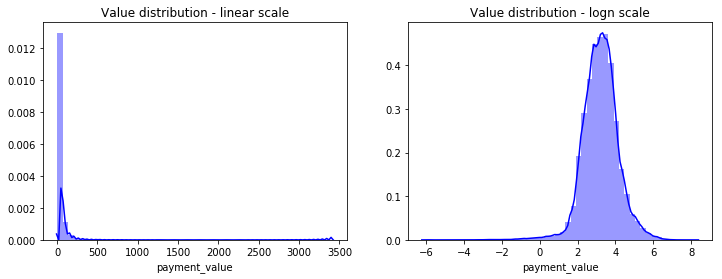

In [9]:
def plot_dist(values, log_values, title, color="blue"):
    fig, axis = plt.subplots(1, 2, figsize=(12,4))
    axis[0].set_title("{} - linear scale".format(title))
    axis[1].set_title("{} - logn scale".format(title))
    ax1 = sns.distplot(values, color=color, ax=axis[0])
    ax2 = sns.distplot(log_values, color=color, ax=axis[1])
log_value = payments.payment_value.apply(lambda x: np.log(x) if x > 0 else 0)
plot_dist(payments.payment_value, log_value, "Value distribution")

#### Payment method
There are four payment methods: credit card, debit card, boleto and voucher. Boleto is a brazillian payment method which is similar to a payment/bank slip.

In [10]:

method_count = payments['payment_type'].value_counts().to_frame().reset_index()
method_value = payments.groupby('payment_type')['payment_value'].sum().to_frame().reset_index()
# Plotly piechart
colors = None
trace1 = go.Pie(labels=method_count['index'], values=method_count['payment_type'],
                domain= {'x': [0, .48]}, marker=dict(colors=colors))
trace2 = go.Pie(labels=method_value['payment_type'], values=method_value['payment_value'],
                domain= {'x': [0.52, 1]}, marker=dict(colors=colors))
layout = dict(title= "Number of payments (left) and Total payments value (right)", 
              height=400, width=800,)
fig = dict(data=[trace1, trace2], layout=layout)
iplot(fig)


lets look into order values and its distribution across payment methods

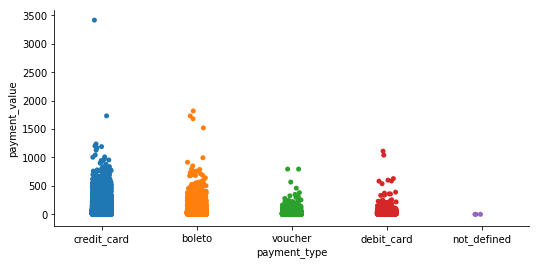

In [11]:
ax = sns.catplot(x="payment_type", y="payment_value",data=payments, aspect=2, height=3.8)

###### Most orders are less than 200 EUR, but we have a wide range of values, so its better to plot the natural log as before:

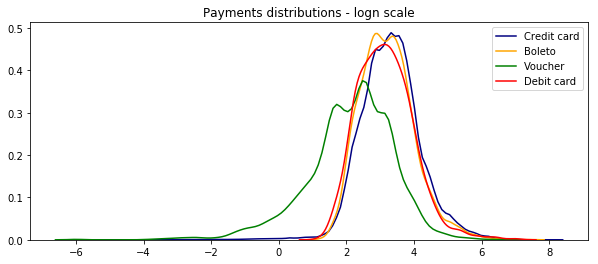

In [12]:
plt.figure(figsize=(10,4))
plt.title("Payments distributions - logn scale")
p1 = sns.kdeplot(payments[payments.payment_type == 'credit_card']['value_log'], color="navy", label='Credit card')
p2 = sns.kdeplot(payments[payments.payment_type == 'boleto']['value_log'], color="orange", label='Boleto')
p3 = sns.kdeplot(payments[payments.payment_type == 'voucher']['value_log'], color="green", label='Voucher')
p4 = sns.kdeplot(payments[payments.payment_type == 'debit_card']['value_log'], color="red", label='Debit card')

#### credit cards can have installments, lets look into it

In [13]:
payments[payments['payment_installments'] > 1]['payment_type'].value_counts().to_frame()

payment_type
credit_card         51338

In [14]:
ins_count = payments.groupby('payment_installments').size()
ins_mean = payments.groupby('payment_installments')['payment_value'].mean()

trace0 = go.Bar(
    x=ins_count.index,
    y=ins_count.values,
    name='Number of orders',
    marker=dict(color='rgb(49,130,189)')
)
trace1 = go.Bar(
    x=ins_mean.index,
    y=ins_mean.values,
    name='Mean value',
    marker=dict(color='rgb(204,204,204)')
)
fig = tools.make_subplots(rows=1, cols=2, print_grid=False)
fig.append_trace(trace0, 1, 1)
fig.append_trace(trace1, 1, 2)

fig['layout'].update(height=400, width=800, title='Number of installments',
                     legend=dict(orientation="h"))
iplot(fig)

C:\Users\Raul\Anaconda3\lib\site-packages\plotly\tools.py:465: DeprecationWarning:

plotly.tools.make_subplots is deprecated, please use plotly.subplots.make_subplots instead



# 2 Orders

In [15]:
unique_ = orders['order_id'].nunique()
print("DataFrame shape: {}; unique order ids: {}".format(orders.shape, unique_))
orders.head(3)

DataFrame shape: (99441, 8); unique order ids: 99441


order_id                       customer_id  \
0  e481f51cbdc54678b7cc49136f2d6af7  9ef432eb6251297304e76186b10a928d   
1  53cdb2fc8bc7dce0b6741e2150273451  b0830fb4747a6c6d20dea0b8c802d7ef   
2  47770eb9100c2d0c44946d9cf07ec65d  41ce2a54c0b03bf3443c3d931a367089   

  order_status order_purchase_timestamp    order_approved_at  \
0    delivered      2017-10-02 10:56:33  2017-10-02 11:07:15   
1    delivered      2018-07-24 20:41:37  2018-07-26 03:24:27   
2    delivered      2018-08-08 08:38:49  2018-08-08 08:55:23   

  order_delivered_carrier_date order_delivered_customer_date  \
0          2017-10-04 19:55:00           2017-10-10 21:25:13   
1          2018-07-26 14:31:00           2018-08-07 15:27:45   
2          2018-08-08 13:50:00           2018-08-17 18:06:29   

  order_estimated_delivery_date  
0           2017-10-18 00:00:00  
1           2018-08-13 00:00:00  
2           2018-09-04 00:00:00

all orders are unique

In [16]:
uniquep_ = pricing['order_id'].nunique()
print("DataFrame shape: {}; unique order ids: {}".format(pricing.shape, uniquep_))
pricing.head()

DataFrame shape: (112650, 6); unique order ids: 98666


order_id  order_item_id  \
0  00010242fe8c5a6d1ba2dd792cb16214              1   
1  00018f77f2f0320c557190d7a144bdd3              1   
2  000229ec398224ef6ca0657da4fc703e              1   
3  00024acbcdf0a6daa1e931b038114c75              1   
4  00042b26cf59d7ce69dfabb4e55b4fd9              1   

                         product_id                         seller_id  \
0  4244733e06e7ecb4970a6e2683c13e61  48436dade18ac8b2bce089ec2a041202   
1  e5f2d52b802189ee658865ca93d83a8f  dd7ddc04e1b6c2c614352b383efe2d36   
2  c777355d18b72b67abbeef9df44fd0fd  5b51032eddd242adc84c38acab88f23d   
3  7634da152a4610f1595efa32f14722fc  9d7a1d34a5052409006425275ba1c2b4   
4  ac6c3623068f30de03045865e4e10089  df560393f3a51e74553ab94004ba5c87   

     price  freight_value  
0  14.7250         3.3225  
1  59.9750         4.9825  
2  49.7500         4.4675  
3   3.2475         3.1975  
4  49.9750         4.5350

In [17]:
full_orders = orders.merge(pricing, on='order_id', how='left')

In [18]:
full_orders.head()

order_id                       customer_id  \
0  e481f51cbdc54678b7cc49136f2d6af7  9ef432eb6251297304e76186b10a928d   
1  53cdb2fc8bc7dce0b6741e2150273451  b0830fb4747a6c6d20dea0b8c802d7ef   
2  47770eb9100c2d0c44946d9cf07ec65d  41ce2a54c0b03bf3443c3d931a367089   
3  949d5b44dbf5de918fe9c16f97b45f8a  f88197465ea7920adcdbec7375364d82   
4  ad21c59c0840e6cb83a9ceb5573f8159  8ab97904e6daea8866dbdbc4fb7aad2c   

  order_status order_purchase_timestamp    order_approved_at  \
0    delivered      2017-10-02 10:56:33  2017-10-02 11:07:15   
1    delivered      2018-07-24 20:41:37  2018-07-26 03:24:27   
2    delivered      2018-08-08 08:38:49  2018-08-08 08:55:23   
3    delivered      2017-11-18 19:28:06  2017-11-18 19:45:59   
4    delivered      2018-02-13 21:18:39  2018-02-13 22:20:29   

  order_delivered_carrier_date order_delivered_customer_date  \
0          2017-10-04 19:55:00           2017-10-10 21:25:13   
1          2018-07-26 14:31:00           2018-08-07 15:27:45   
2          2018-08-08 13:50:00           2018-08-17 18:06:29   
3          2017-11-22 13:39:59           2017-12-02 00:28:42   
4          2018-02-14 19:46:34           2018-02-16 18:17:02   

  order_estimated_delivery_date  order_item_id  \
0           2017-10-18 00:00:00            1.0   
1           2018-08-13 00:00:00            1.0   
2           2018-09-04 00:00:00            1.0   
3           2017-12-15 00:00:00            1.0   
4           2018-02-26 00:00:00            1.0   

                         product_id                         seller_id  \
0  87285b34884572647811a353c7ac498a  3504c0cb71d7fa48d967e0e4c94d59d9   
1  595fac2a385ac33a80bd5114aec74eb8  289cdb325fb7e7f891c38608bf9e0962   
2  aa4383b373c6aca5d8797843e5594415  4869f7a5dfa277a7dca6462dcf3b52b2   
3  d0b61bfb1de832b15ba9d266ca96e5b0  66922902710d126a0e7d26b0e3805106   
4  65266b2da20d04dbe00c5c2d3bb7859e  2c9e548be18521d1c43cde1c582c6de8   

     price  freight_value  
0   7.4975          2.180  
1  29.6750          5.690  
2  39.9750          4.805  
3  11.2500          6.800  
4   4.9750          2.180

In [19]:
# check for values conflicting with the model i.e. value = 0

In [20]:
full_orders.loc[full_orders['price']==0]
full_orders.loc[full_orders['freight_value']==0] #= 0.001 # there are 383 orders with free freight

order_id                       customer_id  \
229     6d7de866a140b19d09e825b2a4e944c7  9e5ce657315b2bdb94033a494041ac25   
230     6d7de866a140b19d09e825b2a4e944c7  9e5ce657315b2bdb94033a494041ac25   
472     d62387acb3914789e712406e9882e549  ad4da04c9e20699c6ad1843af39846d2   
736     f29d0fd6d4e6d5ce550e0b2f9335116c  55216cd56c9eaadec16f03d5aaf11d86   
759     a2ea081c06c12c25c068089e4985745a  fdabedbba76cf0308dedcd99afc66626   
990     f7fd9088963ee4f442fd642219d80fb5  ee339bc1fd51a275cd44985a84e2515d   
1253    d0bec96aad189992b278688279ba1511  f4302056f0c58570522590f8181de2c7   
1345    67d8f4eb477222d7b5b81daa8e007bdd  fb591f7ec5d9419e5a7de2353a87f06b   
1346    67d8f4eb477222d7b5b81daa8e007bdd  fb591f7ec5d9419e5a7de2353a87f06b   
1942    654c6463f421d51939eae082dcc3b15e  84b3985a451fbc57255b5f65c2763cca   
2561    9bd90698ab1e822ca4cb1e2a0de42fd4  88a8cf9e243fe33b9b678a31eb640f70   
2695    24c0b5c7e8f51f85f1bcdbe4cd0f81ac  fc2a8d30702cbc30e24fcd1315030520   
3225    179b63fcfafb80e064370a2ce74c81f7  f63db8b1515a5d3606d101d9b9cf9fe2   
3962    8831eaa951f7563404fa3355d0a89f1e  f03c9c80de7a0a901cd92d8507717007   
4234    31effa440b34ae0432d83ef645db463a  dcad1d81f5929fa310a1a36681535e4d   
4286    beb6927ba358d62ba446c803a6a4d815  9f6184b685d245da0d6868637685223a   
4647    bb3b9252816ff94fc9f21944cfa0b6d1  84353738a84112675537c08797692415   
5048    2ffd4bf0fbadf9acf274c27d822697ca  aab70b85acd198f5a41f3e9f2e34a63f   
5287    64b644100b812930de2286f0b999ece7  aa9d79a05d874fe96ece63ecf1ec008a   
5288    64b644100b812930de2286f0b999ece7  aa9d79a05d874fe96ece63ecf1ec008a   
5964    5fb90fed46dfc44305e1c3ecb5f16a2d  9b242aab6db41736d33c4b915c3b5d06   
5969    971dae4156d63b465b28ce4e45afc849  ba28f5e789469764b295ecdb66470d9b   
6204    152e3e1d1cd5a952b1f4049ff29ab695  729be0ad11a9af7df71af2e9697e513f   
6393    b4a53c6fa9bc78adf59983a160f5470f  cd0ea36f631ecc18f4a781beb4799b43   
6918    6c6abb921625dd44d3d406ce4b890cac  d5961401e349bf22024305eef5fa9119   
6933    295925037780bbbf9d7a2294087693bc  c0499167445cc2f02c12c5270571dbea   
7324    d9aefa5d4ccd369c783f5121e069a470  1d4cdfbfb460efee13d334b446b54bdd   
8339    fb4de3600d359f84927517e78ff9ba54  c33e62b6b6e872a818d2f85f632b5483   
8418    8ec03a8bf91f7efde7eb3ecc6c6b2b03  d90c5c65d840d9daea637a6f04d7832f   
8693    93e85b947c8fbaef6206e8f282ec28f6  0d5f0d55d8ac2ec02aee9ae6cb96b15e   
...                                  ...                               ...   
106149  2a0fa6741aab1f723a7eeaaf58fda1e4  44d64cac6b7087a085f02d3895df8028   
106150  2a0fa6741aab1f723a7eeaaf58fda1e4  44d64cac6b7087a085f02d3895df8028   
106347  a1702545bdfba19345c69fa098b15020  cf5562892befb57faf282d09b61f6f9a   
106710  a52ce374ecd1e12480900aa9f5944e4d  89dfc5a431ab96d5fcf4ead7c032cd75   
107710  d48863aea86f6a6ccbcf40c4d1a38a0c  7af59ba24405ec1365f4500d9e8538ed   
108078  d9d7e5dfa3a521b26058665230c530a2  5850a1aca7d07248dad1103ad272341d   
108265  f9973a8e3b13fd415733a5068d58140d  94ea1224bf06222861ed3bcc73d4e6f8   
108305  0d9ed9d101d80f2accbf309324fea494  ec90d49ce6c2e05379813459bf41a90a   
108385  93b06656d7999e4508fb835a56f85d69  6d7fcad42b71ecdbbb4fbac3f1dff7c4   
108386  93b06656d7999e4508fb835a56f85d69  6d7fcad42b71ecdbbb4fbac3f1dff7c4   
108407  6d5e087df6cf3e6440c325e21c9a1c7c  096e4afe8c8bea72cf73edcca7a74134   
108932  b5f13aa3a46ca3005d39389331866fe4  c490bef02137db10e5a2d0095bee13bb   
108933  b5f13aa3a46ca3005d39389331866fe4  c490bef02137db10e5a2d0095bee13bb   
108934  b5f13aa3a46ca3005d39389331866fe4  c490bef02137db10e5a2d0095bee13bb   
109233  db26bf0c66e8320dd106b9b39ca56fec  11be3313da4285772a39dc6fa8a18cb9   
109644  3e6a8242ed19ca13a5da5659bc36030f  07c6e5fcb00572b328e792042930c1b0   
109805  eae7cb46499add9ed7ea74952c040ddb  d827e5a01164c0de3239a95cb12774c9   
109911  ef830fd38d5bbbd14e58c18b0459a35e  359b0ac938d42de5cfc19de2e8b58d68   
110090  9c1a5eb0f1bff32a9846477115335d36  263ea25eaa79f6e11608a9e7d210bd67   
110674  742cbcd370fd2e637bf3f2570ac5ed2a  7881cb8de850

In [21]:
count_products = full_orders.groupby('order_id').size().value_counts()
trace = go.Bar(
    x= count_products.index,
    y= count_products.values,
    marker=dict(
        color=['rgba(204,204,204,1)', 'rgba(222,45,38,0.8)',
               'rgba(204,204,204,1)', 'rgba(204,204,204,1)',
               'rgba(204,204,204,1)']),
)
layout = go.Layout(title='Number of orders for number of products', height=420, width=420)
fig = go.Figure(data=[trace], layout=layout)
iplot(fig, filename='color-bar')

In [22]:
full_orders.head()

order_id                       customer_id  \
0  e481f51cbdc54678b7cc49136f2d6af7  9ef432eb6251297304e76186b10a928d   
1  53cdb2fc8bc7dce0b6741e2150273451  b0830fb4747a6c6d20dea0b8c802d7ef   
2  47770eb9100c2d0c44946d9cf07ec65d  41ce2a54c0b03bf3443c3d931a367089   
3  949d5b44dbf5de918fe9c16f97b45f8a  f88197465ea7920adcdbec7375364d82   
4  ad21c59c0840e6cb83a9ceb5573f8159  8ab97904e6daea8866dbdbc4fb7aad2c   

  order_status order_purchase_timestamp    order_approved_at  \
0    delivered      2017-10-02 10:56:33  2017-10-02 11:07:15   
1    delivered      2018-07-24 20:41:37  2018-07-26 03:24:27   
2    delivered      2018-08-08 08:38:49  2018-08-08 08:55:23   
3    delivered      2017-11-18 19:28:06  2017-11-18 19:45:59   
4    delivered      2018-02-13 21:18:39  2018-02-13 22:20:29   

  order_delivered_carrier_date order_delivered_customer_date  \
0          2017-10-04 19:55:00           2017-10-10 21:25:13   
1          2018-07-26 14:31:00           2018-08-07 15:27:45   
2          2018-08-08 13:50:00           2018-08-17 18:06:29   
3          2017-11-22 13:39:59           2017-12-02 00:28:42   
4          2018-02-14 19:46:34           2018-02-16 18:17:02   

  order_estimated_delivery_date  order_item_id  \
0           2017-10-18 00:00:00            1.0   
1           2018-08-13 00:00:00            1.0   
2           2018-09-04 00:00:00            1.0   
3           2017-12-15 00:00:00            1.0   
4           2018-02-26 00:00:00            1.0   

                         product_id                         seller_id  \
0  87285b34884572647811a353c7ac498a  3504c0cb71d7fa48d967e0e4c94d59d9   
1  595fac2a385ac33a80bd5114aec74eb8  289cdb325fb7e7f891c38608bf9e0962   
2  aa4383b373c6aca5d8797843e5594415  4869f7a5dfa277a7dca6462dcf3b52b2   
3  d0b61bfb1de832b15ba9d266ca96e5b0  66922902710d126a0e7d26b0e3805106   
4  65266b2da20d04dbe00c5c2d3bb7859e  2c9e548be18521d1c43cde1c582c6de8   

     price  freight_value  
0   7.4975          2.180  
1  29.6750          5.690  
2  39.9750          4.805  
3  11.2500          6.800  
4   4.9750          2.180

## draw freight and price time series

In [23]:
full_orders['datetime'] = pd.to_datetime(full_orders['order_purchase_timestamp'])
df= full_orders[['datetime','price', 'freight_value']]


In [24]:
#df = full_orders[full_orders['datetime'] >= '2017-01-01']

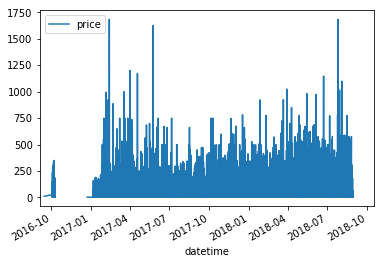

In [25]:
df.plot('datetime', 'price')

In [26]:
df.head()

datetime    price  freight_value
0 2017-10-02 10:56:33   7.4975          2.180
1 2018-07-24 20:41:37  29.6750          5.690
2 2018-08-08 08:38:49  39.9750          4.805
3 2017-11-18 19:28:06  11.2500          6.800
4 2018-02-13 21:18:39   4.9750          2.180

In [27]:
# Sales for month
value_month = df[['datetime', 'price']].copy()
value_month.set_index('datetime', inplace=True)
value_month = value_month.groupby(pd.Grouper(freq="M"))['price'].sum()
trace = go.Bar(x= value_month.index, y= value_month.values)
layout = go.Layout(title='Sales per month (product value)', height=420, width=800)
fig = go.Figure(data=[trace], layout=layout)
iplot(fig)

In [28]:
full_orders.head()

order_id                       customer_id  \
0  e481f51cbdc54678b7cc49136f2d6af7  9ef432eb6251297304e76186b10a928d   
1  53cdb2fc8bc7dce0b6741e2150273451  b0830fb4747a6c6d20dea0b8c802d7ef   
2  47770eb9100c2d0c44946d9cf07ec65d  41ce2a54c0b03bf3443c3d931a367089   
3  949d5b44dbf5de918fe9c16f97b45f8a  f88197465ea7920adcdbec7375364d82   
4  ad21c59c0840e6cb83a9ceb5573f8159  8ab97904e6daea8866dbdbc4fb7aad2c   

  order_status order_purchase_timestamp    order_approved_at  \
0    delivered      2017-10-02 10:56:33  2017-10-02 11:07:15   
1    delivered      2018-07-24 20:41:37  2018-07-26 03:24:27   
2    delivered      2018-08-08 08:38:49  2018-08-08 08:55:23   
3    delivered      2017-11-18 19:28:06  2017-11-18 19:45:59   
4    delivered      2018-02-13 21:18:39  2018-02-13 22:20:29   

  order_delivered_carrier_date order_delivered_customer_date  \
0          2017-10-04 19:55:00           2017-10-10 21:25:13   
1          2018-07-26 14:31:00           2018-08-07 15:27:45   
2          2018-08-08 13:50:00           2018-08-17 18:06:29   
3          2017-11-22 13:39:59           2017-12-02 00:28:42   
4          2018-02-14 19:46:34           2018-02-16 18:17:02   

  order_estimated_delivery_date  order_item_id  \
0           2017-10-18 00:00:00            1.0   
1           2018-08-13 00:00:00            1.0   
2           2018-09-04 00:00:00            1.0   
3           2017-12-15 00:00:00            1.0   
4           2018-02-26 00:00:00            1.0   

                         product_id                         seller_id  \
0  87285b34884572647811a353c7ac498a  3504c0cb71d7fa48d967e0e4c94d59d9   
1  595fac2a385ac33a80bd5114aec74eb8  289cdb325fb7e7f891c38608bf9e0962   
2  aa4383b373c6aca5d8797843e5594415  4869f7a5dfa277a7dca6462dcf3b52b2   
3  d0b61bfb1de832b15ba9d266ca96e5b0  66922902710d126a0e7d26b0e3805106   
4  65266b2da20d04dbe00c5c2d3bb7859e  2c9e548be18521d1c43cde1c582c6de8   

     price  freight_value            datetime  
0   7.4975          2.180 2017-10-02 10:56:33  
1  29.6750          5.690 2018-07-24 20:41:37  
2  39.9750          4.805 2018-08-08 08:38:49  
3  11.2500          6.800 2017-11-18 19:28:06  
4   4.9750          2.180 2018-02-13 21:18:39

In [29]:
orders_items = full_orders.merge(products, on='product_id', how='left')
orders_items = orders_items.merge(translation, on='product_category_name', how='left')

In [30]:
orders_items.head()

order_id                       customer_id  \
0  e481f51cbdc54678b7cc49136f2d6af7  9ef432eb6251297304e76186b10a928d   
1  53cdb2fc8bc7dce0b6741e2150273451  b0830fb4747a6c6d20dea0b8c802d7ef   
2  47770eb9100c2d0c44946d9cf07ec65d  41ce2a54c0b03bf3443c3d931a367089   
3  949d5b44dbf5de918fe9c16f97b45f8a  f88197465ea7920adcdbec7375364d82   
4  ad21c59c0840e6cb83a9ceb5573f8159  8ab97904e6daea8866dbdbc4fb7aad2c   

  order_status order_purchase_timestamp    order_approved_at  \
0    delivered      2017-10-02 10:56:33  2017-10-02 11:07:15   
1    delivered      2018-07-24 20:41:37  2018-07-26 03:24:27   
2    delivered      2018-08-08 08:38:49  2018-08-08 08:55:23   
3    delivered      2017-11-18 19:28:06  2017-11-18 19:45:59   
4    delivered      2018-02-13 21:18:39  2018-02-13 22:20:29   

  order_delivered_carrier_date order_delivered_customer_date  \
0          2017-10-04 19:55:00           2017-10-10 21:25:13   
1          2018-07-26 14:31:00           2018-08-07 15:27:45   
2          2018-08-08 13:50:00           2018-08-17 18:06:29   
3          2017-11-22 13:39:59           2017-12-02 00:28:42   
4          2018-02-14 19:46:34           2018-02-16 18:17:02   

  order_estimated_delivery_date  order_item_id  \
0           2017-10-18 00:00:00            1.0   
1           2018-08-13 00:00:00            1.0   
2           2018-09-04 00:00:00            1.0   
3           2017-12-15 00:00:00            1.0   
4           2018-02-26 00:00:00            1.0   

                         product_id  ...            datetime  \
0  87285b34884572647811a353c7ac498a  ... 2017-10-02 10:56:33   
1  595fac2a385ac33a80bd5114aec74eb8  ... 2018-07-24 20:41:37   
2  aa4383b373c6aca5d8797843e5594415  ... 2018-08-08 08:38:49   
3  d0b61bfb1de832b15ba9d266ca96e5b0  ... 2017-11-18 19:28:06   
4  65266b2da20d04dbe00c5c2d3bb7859e  ... 2018-02-13 21:18:39   

   product_category_name  product_name_lenght product_description_lenght  \
0  utilidades_domesticas                 40.0                      268.0   
1             perfumaria                 29.0                      178.0   
2             automotivo                 46.0                      232.0   
3               pet_shop                 59.0                      468.0   
4              papelaria                 38.0                      316.0   

  product_photos_qty  product_weight_g  product_length_cm  product_height_cm  \
0                4.0             500.0               19.0                8.0   
1                1.0             400.0               19.0               13.0   
2                1.0             420.0               24.0               19.0   
3                3.0             450.0               30.0               10.0   
4                4.0             250.0               51.0               15.0   

   product_width_cm  product_category_name_english  
0              13.0                     housewares  
1              19.0                      perfumery  
2              21.0                           auto  
3              20.0                       pet_shop  
4              15.0                     stationery  

[5 rows x 23 columns]

In [31]:
# Orders by category (less 1000 orders grouped into others)
orders_count =  orders_items.groupby('product_category_name').size()
orders_count['others'] = orders_count[orders_count < 1000].sum()
orders_count = orders_count[orders_count >= 1000].sort_values(ascending=True)
orders_value =  orders_items.groupby('product_category_name')['price'].sum()
orders_value = orders_value[orders_count.index]
translation = pd.Series(translation.product_category_name_english.values, index=translation.product_category_name)

trace0 = go.Bar(
    y=translation[orders_count.index],
    x=orders_count.values,
    name='Number of orders',
    orientation='h',
    marker=dict(color='rgb(49,130,189)')
)
trace1 = go.Bar(
    y=translation[orders_value.index],
    x=orders_value.values,
    name='Total value',
    orientation='h',
    marker=dict(color='rgb(204,204,204)')
)
fig = tools.make_subplots(rows=1, cols=2, print_grid=False)
fig.append_trace(trace0, 1, 1)
fig.append_trace(trace1, 1, 2)

fig['layout'].update(
    height=1000,
    width=800,
    title='Products category',
    margin=dict(l=150, r=10, t=100, b=100),
    legend=dict(orientation="h")
)
fig['layout']['xaxis1'].update(title='Orders by category', domain=[0, 0.40])
fig['layout']['xaxis2'].update(title='Products value by category', domain=[0.6, 1])
iplot(fig)

C:\Users\Raul\Anaconda3\lib\site-packages\plotly\tools.py:465: DeprecationWarning:

plotly.tools.make_subplots is deprecated, please use plotly.subplots.make_subplots instead



In [32]:
#product names

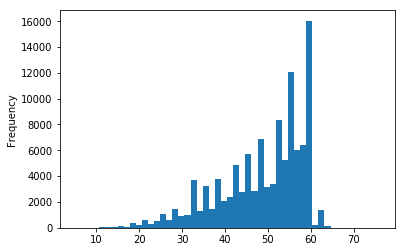

In [33]:
orders_items['product_name_lenght'].plot.hist(bins = 50)

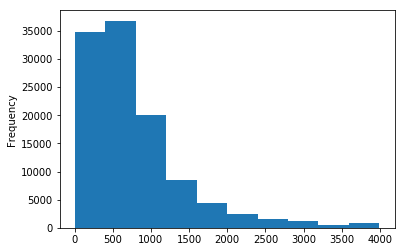

In [34]:
#product description
orders_items['product_description_lenght'].plot.hist(bins = 10)

### number of photos per ordered item

In [35]:
photo_qty = orders_items.groupby('product_photos_qty').size()
photo_value = orders_items.groupby('product_photos_qty')['price'].mean()
trace0 = go.Bar(
    x=photo_qty.index,
    y=photo_qty.values,
    name='Number of Orders',
    marker=dict(color='rgba(222,45,38,0.8)')
)
trace1 = go.Bar(
    x=photo_value.index,
    y=photo_value.values,
    name='Produt mean value',
    marker=dict(color='rgba(204,204,204, 0.8)')
)
fig = tools.make_subplots(rows=1, cols=2, print_grid=False)
fig.append_trace(trace0, 1, 1)
fig.append_trace(trace1, 1, 2)

fig['layout'].update(height=400, width=800, title='Photo quantity',
                     legend=dict(orientation="h"))
#fig['layout']['xaxis1'].update(title='photo quantity', domain=[0, 0.40])
#fig['layout']['xaxis2'].update(title='photo quantity', domain=[0.6, 1])
iplot(fig)

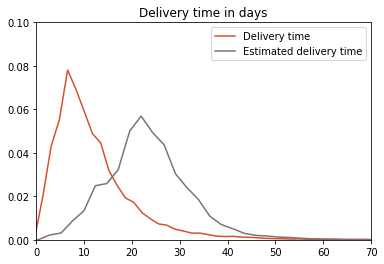

In [36]:
# Convert columns to datetime
orders_items['order_purchase_timestamp'] = pd.to_datetime(orders_items['order_purchase_timestamp'])
orders_items['order_approved_at'] = pd.to_datetime(orders_items['order_approved_at'])
orders_items['order_estimated_delivery_date'] = pd.to_datetime(orders_items['order_estimated_delivery_date'])
orders_items['order_delivered_customer_date'] = pd.to_datetime(orders_items['order_delivered_customer_date'])
# Calculate differences in hours
orders_items['delivery_time'] = (orders_items['order_delivered_customer_date'] - orders_items['order_approved_at']).dt.total_seconds() / 86400
orders_items['estimated_delivery_time'] = (orders_items['order_estimated_delivery_date'] - orders_items['order_approved_at']).dt.total_seconds() / 86400
# Delivery estimated time and actual delivery time
plt.figure(figsize=(6,4))
plt.title("Delivery time in days")
axes = plt.gca()
axes.set_xlim([0,70])
axes.set_ylim([0,0.1])
ax1 = sns.kdeplot(orders_items['delivery_time'].dropna(), color="#D84E30", label='Delivery time')
ax2 = sns.kdeplot(orders_items['estimated_delivery_time'].dropna(), color="#7E7270", label='Estimated delivery time')

# lets look into reviews now

In [37]:
ord_it_revs = orders_items.merge(reviews, on='order_id', how='left')

In [38]:
ord_it_revs.head()

order_id                       customer_id  \
0  e481f51cbdc54678b7cc49136f2d6af7  9ef432eb6251297304e76186b10a928d   
1  53cdb2fc8bc7dce0b6741e2150273451  b0830fb4747a6c6d20dea0b8c802d7ef   
2  47770eb9100c2d0c44946d9cf07ec65d  41ce2a54c0b03bf3443c3d931a367089   
3  949d5b44dbf5de918fe9c16f97b45f8a  f88197465ea7920adcdbec7375364d82   
4  ad21c59c0840e6cb83a9ceb5573f8159  8ab97904e6daea8866dbdbc4fb7aad2c   

  order_status order_purchase_timestamp   order_approved_at  \
0    delivered      2017-10-02 10:56:33 2017-10-02 11:07:15   
1    delivered      2018-07-24 20:41:37 2018-07-26 03:24:27   
2    delivered      2018-08-08 08:38:49 2018-08-08 08:55:23   
3    delivered      2017-11-18 19:28:06 2017-11-18 19:45:59   
4    delivered      2018-02-13 21:18:39 2018-02-13 22:20:29   

  order_delivered_carrier_date order_delivered_customer_date  \
0          2017-10-04 19:55:00           2017-10-10 21:25:13   
1          2018-07-26 14:31:00           2018-08-07 15:27:45   
2          2018-08-08 13:50:00           2018-08-17 18:06:29   
3          2017-11-22 13:39:59           2017-12-02 00:28:42   
4          2018-02-14 19:46:34           2018-02-16 18:17:02   

  order_estimated_delivery_date  order_item_id  \
0                    2017-10-18            1.0   
1                    2018-08-13            1.0   
2                    2018-09-04            1.0   
3                    2017-12-15            1.0   
4                    2018-02-26            1.0   

                         product_id  ... product_width_cm  \
0  87285b34884572647811a353c7ac498a  ...             13.0   
1  595fac2a385ac33a80bd5114aec74eb8  ...             19.0   
2  aa4383b373c6aca5d8797843e5594415  ...             21.0   
3  d0b61bfb1de832b15ba9d266ca96e5b0  ...             20.0   
4  65266b2da20d04dbe00c5c2d3bb7859e  ...             15.0   

   product_category_name_english  delivery_time estimated_delivery_time  \
0                     housewares       8.429144               15.536632   
1                      perfumery      12.502292               17.858021   
2                           auto       9.382708               26.628206   
3                       pet_shop      13.196331               26.176400   
4                     stationery       2.830938               12.069109   

                          review_id  review_score  review_comment_title  \
0  a54f0611adc9ed256b57ede6b6eb5114             4                   NaN   
1  8d5266042046a06655c8db133d120ba5             4      Muito boa a loja   
2  e73b67b67587f7644d5bd1a52deb1b01             5                   NaN   
3  359d03e676b3c069f62cadba8dd3f6e8             5                   NaN   
4  e50934924e227544ba8246aeb3770dd4             5                   NaN   

                              review_comment_message  review_creation_date  \
0  Não testei o produto ainda, mas ele veio corre...   2017-10-11 00:00:00   
1                               Muito bom o produto.   2018-08-08 00:00:00   
2                                                NaN   2018-08-18 00:00:00   
3  O produto foi exatamente o que eu esperava e e...   2017-12-03 00:00:00   
4                                                NaN   2018-02-17 00:00:00   

   review_answer_timestamp  
0      2017-10-12 03:43:48  
1      2018-08-08 18:37:50  
2      2018-08-22 19:07:58  
3      2017-12-05 19:21:58  
4      2018-02-18 13:02:51  

[5 rows x 31 columns]

In [39]:
review_qty = ord_it_revs.groupby('review_score').size()
review_value = ord_it_revs.groupby('review_score')['price'].mean()
trace0 = go.Bar(
    x=review_qty.index,
    y=review_qty.values,
    name='Number of orders',
    marker=dict(color='rgb(49,130,189)')
)
trace1 = go.Bar(
    x=review_value.index,
    y=review_value.values,
    name='Produt mean value',
    marker=dict(color='rgb(204,204,204)')
)
fig = tools.make_subplots(rows=1, cols=2, print_grid=False)
fig.append_trace(trace0, 1, 1)
fig.append_trace(trace1, 1, 2)

fig['layout'].update(height=400, width=800, title='Review Score')
fig['layout']['xaxis1'].update(title='review score', domain=[0, 0.40])
fig['layout']['xaxis2'].update(title='review score', domain=[0.6, 1])
iplot(fig)

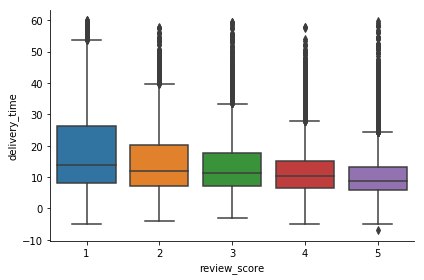

In [40]:
ax = sns.catplot(x="review_score", y="delivery_time", kind="box",
                 data=ord_it_revs[ord_it_revs.delivery_time < 60], height=4, aspect=1.5)

* we see now a connection between delivery time and dissatisfaction

### just to avoid assumptions we look into review word count distributions

C:\Users\Raul\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



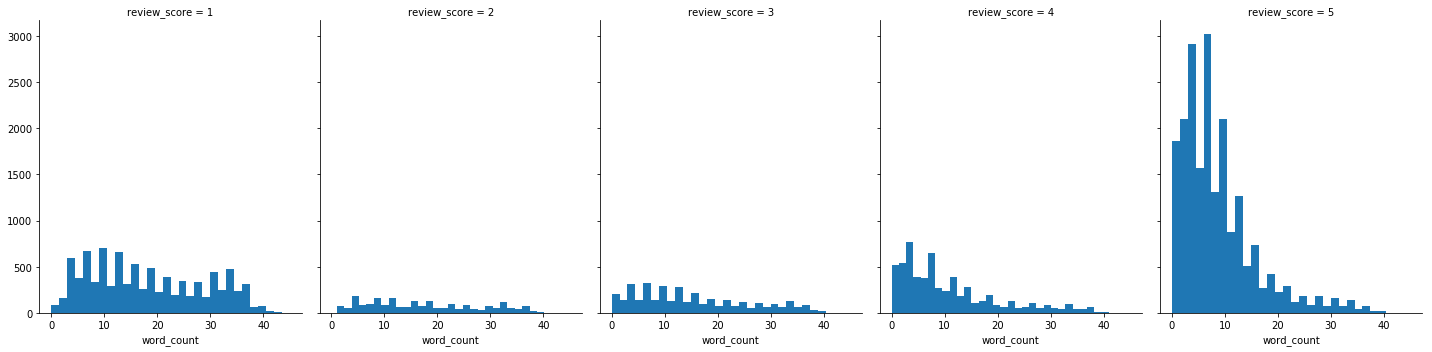

In [41]:
reviews_viz = reviews.dropna(subset=['review_comment_message'])
reviews_viz['word_count'] = reviews_viz.review_comment_message.apply(lambda x: len(str(x).split()))

g = sns.FacetGrid(data=reviews_viz, col='review_score',height=5, aspect=0.8)
draw_me = g.map(plt.hist, 'word_count', bins=30)
draw_me

# now introducing NLP to reduce CC and CSM workload
* enabling company wide communication - marketing included
* bypassing time lenght that a FTE needs to get to know the customer and issues with products

In [42]:
# we will be using orders and reviews for this purpose, so we load them and process the data
r = reviews
o = orders

In [43]:
# Convert columns to datetime
r['review_creation_date'] = pd.to_datetime(reviews['review_creation_date'], format='%Y/%m/%d %H:%M:%S')
r['review_answer_timestamp'] = pd.to_datetime(reviews['review_answer_timestamp'], format='%Y/%m/%d %H:%M:%S')
o['order_purchase_timestamp'] = pd.to_datetime(orders['order_purchase_timestamp'], format='%Y/%m/%d %H:%M:%S')
o['order_delivered_customer_date'] = pd.to_datetime(orders['order_delivered_customer_date'], format='%Y/%m/%d %H:%M:%S')

# Merge with orders
r = pd.merge(r, o, on='order_id')

# Remove unused columns
to_drop = [
    'review_id', 
    'order_id', 
    'customer_id', 
    'review_comment_title', 
    'order_approved_at', 
    'order_delivered_carrier_date', 
    'order_estimated_delivery_date'
]
r.drop(columns=to_drop, inplace=True)

In [44]:
r.head()

review_score                             review_comment_message  \
0             4                                                NaN   
1             5                                                NaN   
2             5                                                NaN   
3             5              Recebi bem antes do prazo estipulado.   
4             5  Parabéns lojas lannister adorei comprar pela I...   

  review_creation_date review_answer_timestamp order_status  \
0           2018-01-18     2018-01-18 21:46:59    delivered   
1           2018-03-10     2018-03-11 03:05:13    delivered   
2           2018-02-17     2018-02-18 14:36:24    delivered   
3           2017-04-21     2017-04-21 22:02:06    delivered   
4           2018-03-01     2018-03-02 10:26:53    delivered   

  order_purchase_timestamp order_delivered_customer_date  
0      2018-01-11 15:30:49           2018-01-17 18:42:41  
1      2018-02-28 12:25:19           2018-03-09 23:17:20  
2      2018-02-03 09:56:22           2018-02-16 17:28:48  
3      2017-04-09 17:41:13           2017-04-20 09:08:35  
4      2018-02-10 10:59:03           2018-02-28 16:33:35

In [45]:
r['review_creation_delay'] = (r['review_creation_date'] - r['order_purchase_timestamp']).dt.days


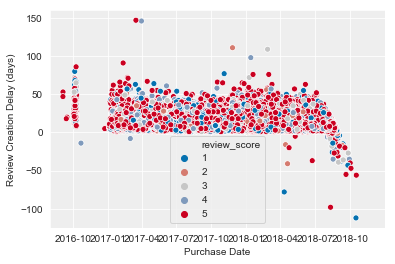

In [46]:
sns.set_style('darkgrid', {'axes.facecolor': '#eeeeee'})
sns.scatterplot(
    x=r['order_purchase_timestamp'], 
    y=r['review_creation_delay'], 
    hue='review_score', 
    palette = sns.color_palette(('#0571b0', '#d57b6f', '#c6c6c6', '#7f9abc', '#ca0020')),
    data=reviews
).set(
    xlabel='Purchase Date', 
    ylabel='Review Creation Delay (days)',
    xlim=(datetime(2016, 8, 1), datetime(2018, 12, 31))
);
resize_plot = lambda: plt.gcf().set_size_inches(12, 5)

##### Steps to a basic NLP stack
1. Convert text to lowercase
2. Compatibility decomposition (decomposes ã into a~)
3. Encode to ascii ignoring errors (removes accents), reencoding again to utf8
4. Tokenization, to break a sentence into words
5. Removal of stop words and non-alpha strings (special characters and numbers)
6. (**)ISSUE: Lemmatization (transform into base or dictionary form of a word)*
7. N-grams creation (group lemmas next to each other, by comment)
8. Grouping n-grams of all comments together

(*) Lemmatization is not available for Portuguese words with the NLTK package. Another approach would be to translate the text to English first, but I'll leave this alternative for a later time.

In [47]:
def remove_accents(text):
    return unicodedata.normalize('NFKD', text).encode('ascii', errors='ignore').decode('utf-8')

STOP_WORDS = set(remove_accents(w) for w in nltk.corpus.stopwords.words('portuguese'))
STOP_WORDS.remove('nao') # This word is key to understand delivery problems later


def comments_to_words(comment):
    lowered = comment.lower()
    normalized = remove_accents(lowered)
    tokens = nltk.tokenize.word_tokenize(normalized)
    words = tuple(t for t in tokens if t not in STOP_WORDS and t.isalpha())
    return words

def words_to_ngrams(words):
    unigrams, bigrams, trigrams = [], [], []
    for comment_words in words:
        unigrams.extend(comment_words)
        bigrams.extend(' '.join(bigram) for bigram in nltk.bigrams(comment_words))
        trigrams.extend(' '.join(trigram) for trigram in nltk.trigrams(comment_words))
    
    return unigrams, bigrams, trigrams

def plot_freq(tokens, color):
    resize_plot()
    nltk.FreqDist(tokens).plot(25, cumulative=False, color=color)

##### material is to analize 1 and 5 star reviews

In [48]:
commented_reviews = r[r['review_comment_message'].notnull()].copy()
commented_reviews['review_comment_words'] = commented_reviews['review_comment_message'].apply(comments_to_words)

reviews_5s = commented_reviews[commented_reviews['review_score'] == 5]
reviews_1s = commented_reviews[commented_reviews['review_score'] == 1]

unigrams_5s, bigrams_5s, trigrams_5s = words_to_ngrams(reviews_5s['review_comment_words'])
unigrams_1s, bigrams_1s, trigrams_1s = words_to_ngrams(reviews_1s['review_comment_words'])

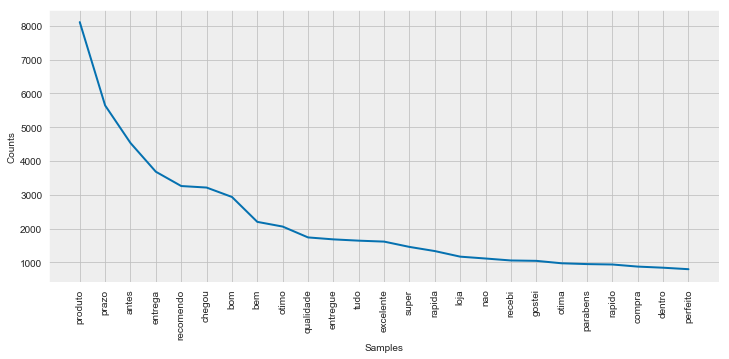

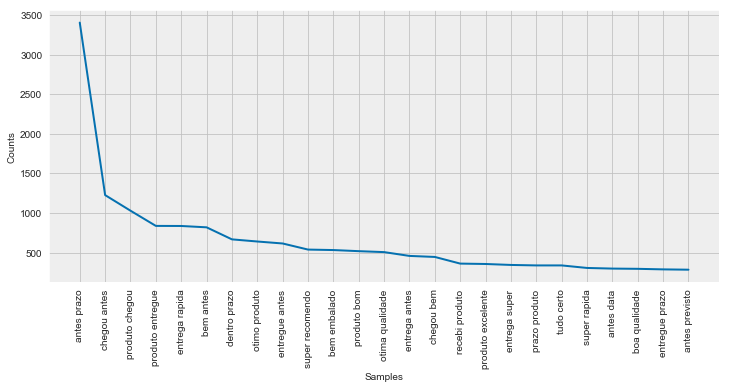

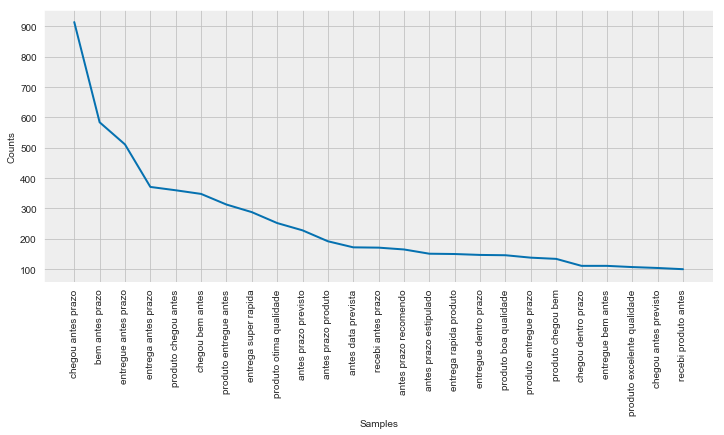

In [49]:
plot_freq(unigrams_5s, '#0571b0')
plot_freq(bigrams_5s, '#0571b0')
plot_freq(trigrams_5s, '#0571b0')

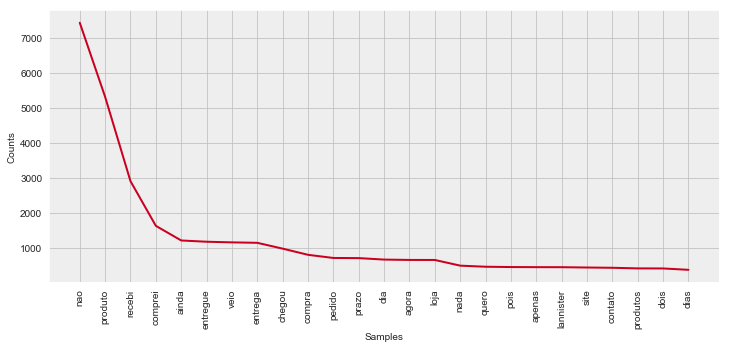

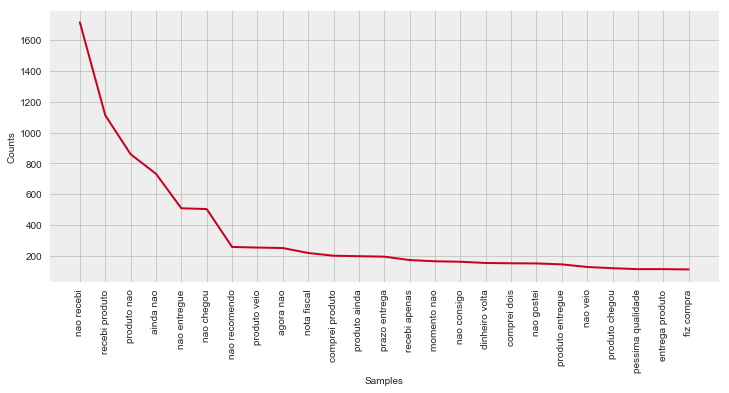

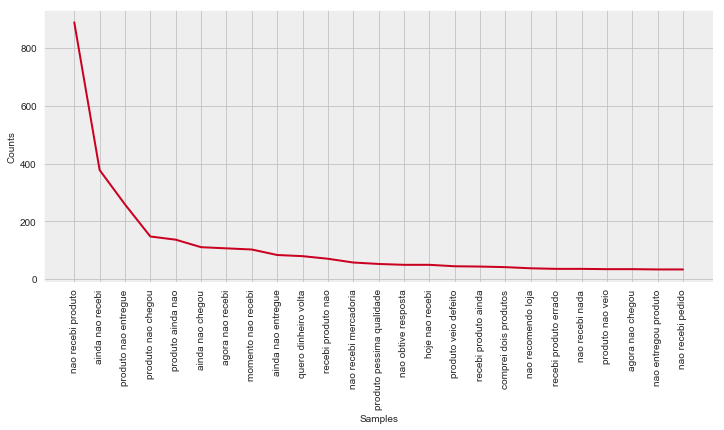

In [50]:
plot_freq(unigrams_1s, '#ca0020')
plot_freq(bigrams_1s, '#ca0020')
plot_freq(trigrams_1s, '#ca0020')

### To sumamrize we can use a word cloud for each

In [51]:

def rgb_float_to_int(rgb):
    return tuple(int(255 * c) for c in rgb)

WORDCLOUD_1S_PALETTE = [rgb_float_to_int(rgb) for rgb in sns.color_palette('Reds', n_colors=9)[2:]]
WORDCLOUD_5S_PALETTE = [rgb_float_to_int(rgb) for rgb in sns.color_palette('Blues', n_colors=9)[2:]]

def get_1s_color(*args, **kwargs):
    return random.choice(WORDCLOUD_1S_PALETTE)

def get_5s_color(*args, **kwargs):
    return random.choice(WORDCLOUD_5S_PALETTE)

def plot_wordcloud(words, style):
    if style == '1s':
        color_function = get_1s_color
        mask_fn = 'bad.png'
        
    elif style == '5s':
        color_function = get_5s_color
        mask_fn = 'heart.png'
        
    mask = np.array(Image.open(f'C:/Users/Raul/Desktop/SPICED/projects/bootcamp_final/bootcamp_final/data/{mask_fn}'))[:, :, 3]
    mask_icon = mask == 0
    mask_bg = mask > 0
    mask[mask_icon] = 255
    mask[mask_bg] = 0
        
    wordcloud = WordCloud(background_color='white', mask=mask)
    wordcloud.generate(' '.join(words))
    wordcloud.recolor(color_func=color_function)
    
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis('off')
    plt.gcf().set_size_inches(16, 10)

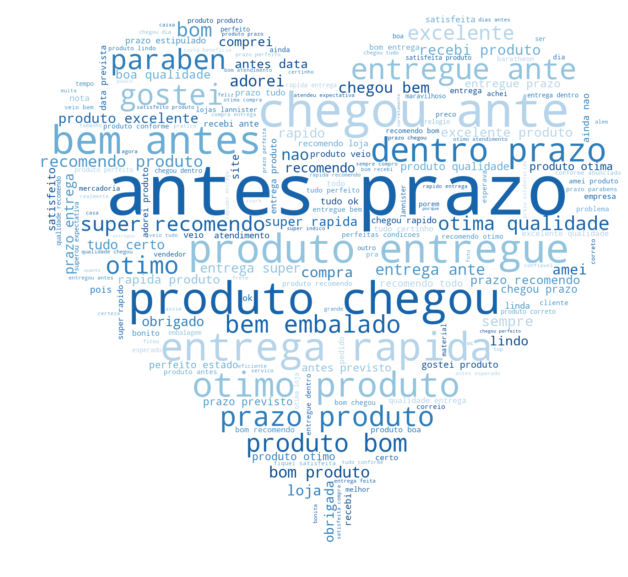

In [52]:
plot_wordcloud(unigrams_5s, '5s')

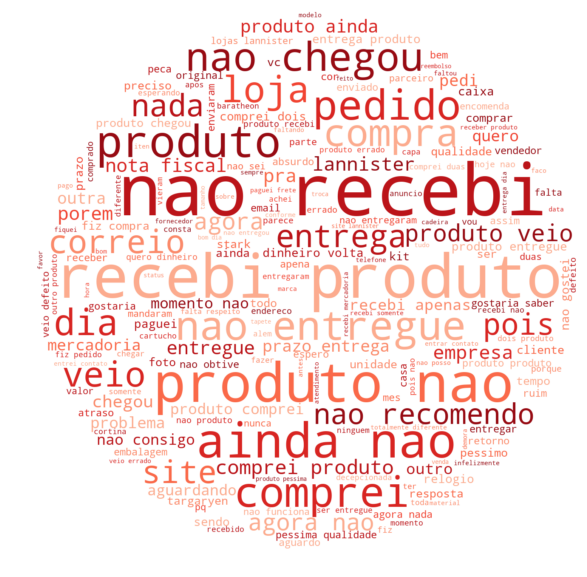

In [53]:
plot_wordcloud(unigrams_1s, '1s')

## create the geolocation displaying animated revenue and market growth

In [54]:
# Gets the first three and four first digits of zip codes, we will explore this further to understand how zip codes works
geo['geolocation_zip_code_prefix_1_digits'] = geo['geolocation_zip_code_prefix'].str[0:1]
geo['geolocation_zip_code_prefix_2_digits'] = geo['geolocation_zip_code_prefix'].str[0:2]
geo['geolocation_zip_code_prefix_3_digits'] = geo['geolocation_zip_code_prefix'].str[0:3]
geo['geolocation_zip_code_prefix_4_digits'] = geo['geolocation_zip_code_prefix'].str[0:4]
geo.head(3)

geolocation_zip_code_prefix  geolocation_lat  geolocation_lng  \
0                       01037       -23.545621       -46.639292   
1                       01046       -23.546081       -46.644820   
2                       01046       -23.546129       -46.642951   

  geolocation_city geolocation_state geolocation_zip_code_prefix_1_digits  \
0        sao paulo                SP                                    0   
1        sao paulo                SP                                    0   
2        sao paulo                SP                                    0   

  geolocation_zip_code_prefix_2_digits geolocation_zip_code_prefix_3_digits  \
0                                   01                                  010   
1                                   01                                  010   
2                                   01                                  010   

  geolocation_zip_code_prefix_4_digits  
0                                 0103  
1                                 0104  
2                                 0104

In [55]:
# Removing some outliers
#Brazils most Northern spot is at 5 deg 16′ 27.8″ N latitude.;
geo = geo[geo.geolocation_lat <= 5.27438888]
#it’s most Western spot is at 73 deg, 58′ 58.19″W Long.
geo = geo[geo.geolocation_lng >= -73.98283055]
#It’s most southern spot is at 33 deg, 45′ 04.21″ S Latitude.
geo = geo[geo.geolocation_lat >= -33.75116944]
#It’s most Eastern spot is 34 deg, 47′ 35.33″ W Long.
geo = geo[geo.geolocation_lng <=  -34.79314722]

In [56]:
from datashader.utils import lnglat_to_meters as webm
x, y = webm(geo.geolocation_lng, geo.geolocation_lat)
geo['x'] = pd.Series(x)
geo['y'] = pd.Series(y)

In [57]:
# transforming the prefixes to int for plotting purposes
geo['geolocation_zip_code_prefix'] = geo['geolocation_zip_code_prefix'].astype(int)
geo['geolocation_zip_code_prefix_1_digits'] = geo['geolocation_zip_code_prefix_1_digits'].astype(int)
geo['geolocation_zip_code_prefix_2_digits'] = geo['geolocation_zip_code_prefix_2_digits'].astype(int)
geo['geolocation_zip_code_prefix_3_digits'] = geo['geolocation_zip_code_prefix_3_digits'].astype(int)
geo['geolocation_zip_code_prefix_4_digits'] = geo['geolocation_zip_code_prefix_4_digits'].astype(int)

Loading BokehJS ...

<img src='data:image/png;base64,iVBORw0KGgoAAAANSUhEUgAAAEAAAABACAYAAACqaXHeAAAABHNCSVQICAgIfAhkiAAAAAlwSFlz
AAAB+wAAAfsBxc2miwAAABl0RVh0U29mdHdhcmUAd3d3Lmlua3NjYXBlLm9yZ5vuPBoAAA6zSURB
VHic7ZtpeFRVmsf/5966taWqUlUJ2UioBBJiIBAwCZtog9IOgjqACsogKtqirT2ttt069nQ/zDzt
tI4+CrJIREFaFgWhBXpUNhHZQoKBkIUASchWla1S+3ar7r1nPkDaCAnZKoQP/D7mnPOe9/xy76n3
nFSAW9ziFoPFNED2LLK5wcyBDObkb8ZkxuaoSYlI6ZcOKq1eWFdedqNzGHQBk9RMEwFAASkk0Xw3
ETacDNi2vtvc7L0ROdw0AjoSotQVkKSvHQz/wRO1lScGModBFbDMaNRN1A4tUBCS3lk7BWhQkgpD
lG4852/+7DWr1R3uHAZVQDsbh6ZPN7CyxUrCzJMRouusj0ipRwD2uKm0Zn5d2dFwzX1TCGhnmdGo
G62Nna+isiUqhkzuKrkQaJlPEv5mFl2fvGg2t/VnzkEV8F5ioioOEWkLG86fvbpthynjdhXYZziQ
x1hC9J2NFyi8vCTt91Fh04KGip0AaG9zuCk2wQCVyoNU3Hjezee9bq92duzzTmxsRJoy+jEZZZYo
GTKJ6SJngdJqAfRzpze0+jHreUtPc7gpBLQnIYK6BYp/uGhw9YK688eu7v95ysgshcg9qSLMo3JC
4jqLKQFBgdKDPoQ+Pltb8dUyQLpeDjeVgI6EgLIQFT5tEl3rn2losHVsexbZ3EyT9wE1uGdkIPcy
BGxn8QUq1QrA5nqW5i2tLqvrrM9NK6AdkVIvL9E9bZL/oyfMVd/jqvc8LylzRBKDJSzIExwhQzuL
QYGQj4rHfFTc8mUdu3E7yoLtbTe9gI4EqVgVkug2i5+uXGo919ixbRog+3fTbQ8qJe4ZOYNfMoTI
OoshUNosgO60AisX15aeI2PSIp5KiFLI9ubb1vV3Qb2ltwLakUCDAkWX7/nHKRmmGIl9VgYsUhJm
2NXjKYADtM1ygne9QQDIXlk49FBstMKx66D1v4+XuQr7vqTe0VcBHQlRWiOCbmmSYe2SqtL6q5rJ
zsTb7lKx3FKOYC4DoqyS/B5bvLPxvD9Qtf6saxYLQGJErmDOdOMr/zo96km1nElr8bmPOBwI9COv
HnFPRIwmkSOv9kcAS4heRsidOkpeWBgZM+UBrTFAXNYL5Vf2ii9c1trNzpYdaoVil3WIc+wdk+gQ
noie3ecCcxt9ITcLAPWt/laGEO/9U6PmzZkenTtsSMQ8uYywJVW+grCstAvCIaAdArAsIWkRDDs/
KzLm2YcjY1Lv0UdW73HabE9n6V66cxSzfEmuJssTpKGVp+0vHq73FwL46eOjpMpbRAnNmJFrGJNu
Ukf9Yrz+3rghiumCKNXXWPhLYcjxGsIpoCMsIRoFITkW8AuyM8jC1+/QLx4bozCEJIq38+1rtpR6
V/yzb8eBlRb3fo5l783N0CWolAzJHaVNzkrTzlEp2bQ2q3TC5gn6wpnoQAmwSiGh2GitnTmVMc5O
UyfKWUKCIsU7+fZDKwqdT6DDpvkzAX4/+AMFjk0tDp5GRXLpQ2MUmhgDp5gxQT8+Y7hyPsMi8uxF
71H0oebujHALECjFKaW9Lm68n18wXp2kVzIcABytD5iXFzg+WVXkegpAsOOYziqo0OkK76GyquC3
ltZAzMhhqlSNmmWTE5T6e3IN05ITFLM4GdN0vtZ3ob8Jh1NAKXFbm5PtLU/eqTSlGjkNAJjdgn/N
aedXa0tdi7+t9G0FIF49rtMSEgAs1kDLkTPO7ebm4IUWeyh1bKomXqlgMG6kJmHcSM0clYLJ8XtR
1GTnbV3F6I5wCGikAb402npp1h1s7LQUZZSMIfALFOuL3UUrfnS8+rez7v9qcold5tilgHbO1fjK
9ubb17u9oshxzMiUBKXWqJNxd+fqb0tLVs4lILFnK71H0Ind7uiPgACVcFJlrb0tV6DzxqqTIhUM
CwDf1/rrVhTa33/3pGPxJYdQ2l2cbgVcQSosdx8uqnDtbGjh9SlDVSMNWhlnilfqZk42Th2ZpLpf
xrHec5e815zrr0dfBZSwzkZfqsv+1FS1KUknUwPARVvItfKUY+cn57yP7qv07UE3p8B2uhUwLk09
e0SCOrK+hbdYHYLjRIl71wWzv9jpEoeOHhGRrJAzyEyNiJuUqX0g2sBN5kGK6y2Blp5M3lsB9Qh4
y2Ja6x6+i0ucmKgwMATwhSjdUu49tKrQ/pvN5d53ml2CGwCmJipmKjgmyuaXzNeL2a0AkQ01Th5j
2DktO3Jyk8f9vcOBQHV94OK+fPumJmvQHxJoWkaKWq9Vs+yUsbq0zGT1I4RgeH2b5wef7+c7bl8F
eKgoHVVZa8ZPEORzR6sT1BzDUAD/d9F78e2Tzv99v8D+fLVTqAKAsbGamKey1Mt9Ann4eH3gTXTz
idWtAJ8PQWOk7NzSeQn/OTHDuEikVF1R4z8BQCy+6D1aWRfY0tTGG2OM8rRoPaeIj5ZHzJxszElN
VM8K8JS5WOfv8mzRnQAKoEhmt8gyPM4lU9SmBK1MCQBnW4KONT86v1hZ1PbwSXPw4JWussVjtH9Y
NCoiL9UoH/6PSu8jFrfY2t36erQHXLIEakMi1SydmzB31h3GGXFDFNPaK8Rme9B79Ixrd0WN+1ij
NRQ/doRmuFLBkHSTOm5GruG+pFjFdAmorG4IXH1Qua6ASniclfFtDYt+oUjKipPrCQB7QBQ2lrgP
fFzm+9XWUtcqJ3/5vDLDpJ79XHZk3u8nGZ42qlj1+ydtbxysCezrydp6ugmipNJ7WBPB5tydY0jP
HaVNzs3QzeE4ZpTbI+ZbnSFPbVOw9vsfnVvqWnirPyCNGD08IlqtYkh2hjZ5dErEQzoNm+6ykyOt
Lt5/PQEuSRRKo22VkydK+vvS1XEKlhCJAnsqvcVvH7f/ZU2R67eXbMEGAMiIV5oWZWiWvz5Fv2xG
sjqNJQRvn3Rs2lji/lNP19VjAQDgD7FHhujZB9OGqYxRkZxixgRDVlqS6uEOFaJUVu0rPFzctrnF
JqijImVp8dEKVWyUXDk92zAuMZ6bFwpBU1HrOw6AdhQgUooChb0+ItMbWJitSo5Ws3IAOGEOtL53
0vHZih9sC4vtofZ7Qu6523V/fmGcds1TY3V36pUsBwAbSlxnVh2xLfAD/IAIMDf7XYIkNmXfpp2l
18rkAJAy9HKFaIr/qULkeQQKy9zf1JgDB2uaeFNGijo5QsUyacNUUTOnGO42xSnv4oOwpDi1zYkc
efUc3I5Gk6PhyTuVKaOGyLUAYPGIoY9Pu/atL/L92+4q9wbflRJ2Trpm/jPjdBtfnqB/dIThcl8A
KG7hbRuKnb8qsQsVvVlTrwQAQMUlf3kwJI24Z4JhPMtcfng5GcH49GsrxJpGvvHIaeem2ma+KSjQ
lIwUdYyCY8j4dE1KzijNnIP2llF2wcXNnsoapw9XxsgYAl6k+KzUXbi2yP3KR2ecf6z3BFsBICdW
nvnIaG3eHybqX7vbpEqUMT+9OL4Qpe8VON7dXuFd39v19FoAABRVePbGGuXTszO0P7tu6lghUonE
llRdrhArLvmKdh9u29jcFiRRkfLUxBiFNiqSU9icoZQHo5mYBI1MBgBH6wMNb+U7Pnw337H4gi1Y
ciWs+uks3Z9fztUvfzxTm9Ne8XXkvQLHNytOOZeiD4e0PgkAIAYCYknKUNUDSXEKzdWNpnil7r4p
xqkjTarZMtk/K8TQ6Qve78qqvXurGwIJqcOUKfUWHsm8KGvxSP68YudXq4pcj39X49uOK2X142O0
Tz5/u/7TVybqH0rSya6ZBwD21/gubbrgWdDgEOx9W
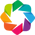

In [58]:
# plot wtih holoviews + datashader - bokeh with map background
import holoviews as hv
import geoviews as gv
import datashader as ds
from colorcet import fire, rainbow, bgy, bjy, bkr, kb, kr
from datashader.colors import colormap_select, Greys9
from holoviews.streams import RangeXY
from holoviews.operation.datashader import datashade, dynspread, rasterize
from bokeh.io import push_notebook, show, output_notebook
output_notebook()
hv.extension('bokeh')

%opts Overlay [width=800 height=600 toolbar='above' xaxis=None yaxis=None]
%opts QuadMesh [tools=['hover'] colorbar=True] (alpha=0 hover_alpha=0.2)

T = 0.05
PX = 1 

def plot_map(data, label, agg_data, agg_name, cmap):
    url="http://server.arcgisonline.com/ArcGIS/rest/services/Canvas/World_Dark_Gray_Base/MapServer/tile/{Z}/{Y}/{X}.png"
    geomap = gv.WMTS(url)
    points = hv.Points(gv.Dataset(data, kdims=['x', 'y'], vdims=[agg_name]))
    agg = datashade(points, element_type=gv.Image, aggregator=agg_data, cmap=cmap)
    zip_codes = dynspread(agg, threshold=T, max_px=PX)
    hover = hv.util.Dynamic(rasterize(points, aggregator=agg_data, width=50, height=25, streams=[RangeXY]), operation=hv.QuadMesh)
    hover = hover.options(cmap=cmap)
    img = geomap * zip_codes * hover
    img = img.relabel(label)
    return img

In [59]:
brazil = geo
agg_name = 'geolocation_zip_code_prefix'
plot_map(brazil, 'Zip Codes in Brazil', ds.min(agg_name), agg_name, cmap=rainbow)

:DynamicMap   []
   :Overlay
      .WMTS.I     :WMTS   [Longitude,Latitude]
      .RGB.I      :RGB   [x,y]   (R,G,B,A)
      .QuadMesh.I :QuadMesh   [x,y]   (geolocation_zip_code_prefix)

In [60]:
# plot wtih datashader - image with black background
import datashader as ds
from datashader import transfer_functions as tf
from functools import partial
from datashader.utils import export_image
from IPython.core.display import HTML, display
from colorcet import fire, rainbow, bgy, bjy, bkr, kb, kr

background = "black"
cm = partial(colormap_select, reverse=(background!="black"))
export = partial(export_image, background = background, export_path="export")
display(HTML("<style>.container { width:100% !important; }</style>"))
W = 700 

def create_map(data, cmap, data_agg, export_name='img'):
    pad = (data.x.max() - data.x.min())/50
    x_range, y_range = ((data.x.min() - pad, data.x.max() + pad), 
                             (data.y.min() - pad, data.y.max() + pad))

    ratio = (y_range[1] - y_range[0]) / (x_range[1] - x_range[0])

    plot_width  = int(W)
    plot_height = int(plot_width * ratio)
    if ratio > 1.5:
        plot_height = 550
        plot_width = int(plot_height / ratio)
        
    cvs = ds.Canvas(plot_width=plot_width, plot_height=plot_height, x_range=x_range, y_range=y_range)

    agg = cvs.points(data, 'x', 'y', data_agg)
    img = tf.shade(agg, cmap=cmap, how='eq_hist')
    return export(img, export_name)

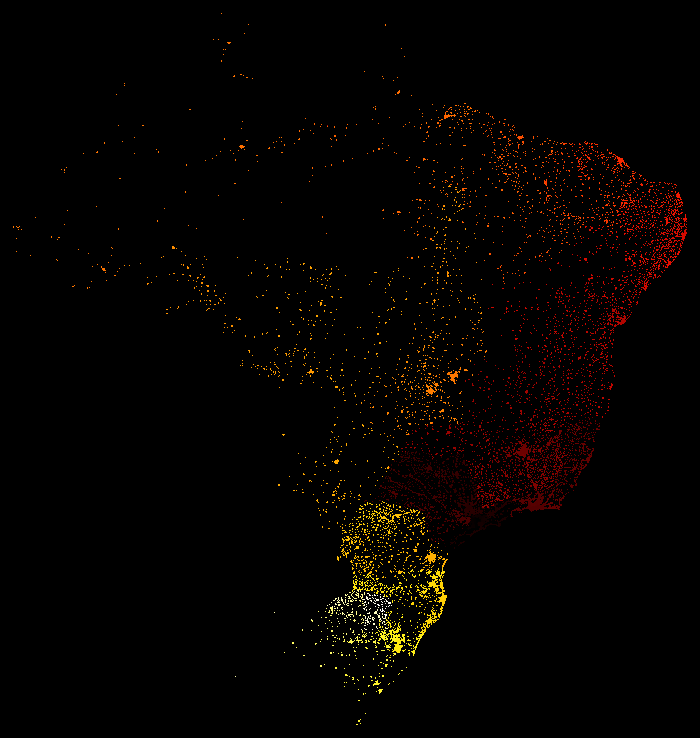

In [61]:
create_map(brazil, fire, ds.mean(agg_name),'brazil_zip_codes')

In [62]:
customers = pd.read_csv("ecom_customers.csv", dtype={'customer_zip_code_prefix': str})

In [63]:
# getting the first 3 digits of customer zipcode
customers['customer_zip_code_prefix_3_digits'] = customers['customer_zip_code_prefix'].str.slice(0, 3)
customers['customer_zip_code_prefix_3_digits'] = customers['customer_zip_code_prefix_3_digits'].astype(int)

brazil_geo = geo.set_index('geolocation_zip_code_prefix_3_digits').copy()

In [64]:
brazil_geo.head()

geolocation_zip_code_prefix  \
geolocation_zip_code_prefix_3_digits                                
10                                                           1037   
10                                                           1046   
10                                                           1046   
10                                                           1041   
10                                                           1035   

                                      geolocation_lat  geolocation_lng  \
geolocation_zip_code_prefix_3_digits                                     
10                                         -23.545621       -46.639292   
10                                         -23.546081       -46.644820   
10                                         -23.546129       -46.642951   
10                                         -23.544392       -46.639499   
10                                         -23.541578       -46.641607   

                                     geolocation_city geolocation_state  \
geolocation_zip_code_prefix_3_digits                                      
10                                          sao paulo                SP   
10                                          sao paulo                SP   
10                                          sao paulo                SP   
10                                          sao paulo                SP   
10                                          sao paulo                SP   

                                      geolocation_zip_code_prefix_1_digits  \
geolocation_zip_code_prefix_3_digits                                         
10                                                                       0   
10                                                                       0   
10                                                                       0   
10                                                                       0   
10                                                                       0   

                                      geolocation_zip_code_prefix_2_digits  \
geolocation_zip_code_prefix_3_digits                                         
10                                                                       1   
10                                                                       1   
10                                                                       1   
10                                                                       1   
10                                                                       1   

                                      geolocation_zip_code_prefix_4_digits  \
geolocation_zip_code_prefix_3_digits                                         
10                                                                     103   
10                                                                     104   
10                                                                     104   
10                                                                     104   
10                                                                     103   

                                                 x             y  
geolocation_zip_code_prefix_3_digits                              
10                                   -5.191862e+06 -2.698137e+06  
10                                   -5.192478e+06 -2.698193e+06  
10                                   -5.192270e+06 -2.698199e+06  
10                                   -5.191885e+06 -2.697988e+06  
10                                   -5.192120e+06 -2.697646e+06

In [65]:
orders.head()

order_id                       customer_id  \
0  e481f51cbdc54678b7cc49136f2d6af7  9ef432eb6251297304e76186b10a928d   
1  53cdb2fc8bc7dce0b6741e2150273451  b0830fb4747a6c6d20dea0b8c802d7ef   
2  47770eb9100c2d0c44946d9cf07ec65d  41ce2a54c0b03bf3443c3d931a367089   
3  949d5b44dbf5de918fe9c16f97b45f8a  f88197465ea7920adcdbec7375364d82   
4  ad21c59c0840e6cb83a9ceb5573f8159  8ab97904e6daea8866dbdbc4fb7aad2c   

  order_status order_purchase_timestamp    order_approved_at  \
0    delivered      2017-10-02 10:56:33  2017-10-02 11:07:15   
1    delivered      2018-07-24 20:41:37  2018-07-26 03:24:27   
2    delivered      2018-08-08 08:38:49  2018-08-08 08:55:23   
3    delivered      2017-11-18 19:28:06  2017-11-18 19:45:59   
4    delivered      2018-02-13 21:18:39  2018-02-13 22:20:29   

  order_delivered_carrier_date order_delivered_customer_date  \
0          2017-10-04 19:55:00           2017-10-10 21:25:13   
1          2018-07-26 14:31:00           2018-08-07 15:27:45   
2          2018-08-08 13:50:00           2018-08-17 18:06:29   
3          2017-11-22 13:39:59           2017-12-02 00:28:42   
4          2018-02-14 19:46:34           2018-02-16 18:17:02   

  order_estimated_delivery_date  
0           2017-10-18 00:00:00  
1           2018-08-13 00:00:00  
2           2018-09-04 00:00:00  
3           2017-12-15 00:00:00  
4           2018-02-26 00:00:00

In [66]:
orders_map = orders.merge(customers, on='customer_id')
orders_map = orders_map.merge(payments, on = 'order_id')

In [67]:
orders_map.head()

order_id                       customer_id  \
0  e481f51cbdc54678b7cc49136f2d6af7  9ef432eb6251297304e76186b10a928d   
1  e481f51cbdc54678b7cc49136f2d6af7  9ef432eb6251297304e76186b10a928d   
2  e481f51cbdc54678b7cc49136f2d6af7  9ef432eb6251297304e76186b10a928d   
3  53cdb2fc8bc7dce0b6741e2150273451  b0830fb4747a6c6d20dea0b8c802d7ef   
4  47770eb9100c2d0c44946d9cf07ec65d  41ce2a54c0b03bf3443c3d931a367089   

  order_status order_purchase_timestamp    order_approved_at  \
0    delivered      2017-10-02 10:56:33  2017-10-02 11:07:15   
1    delivered      2017-10-02 10:56:33  2017-10-02 11:07:15   
2    delivered      2017-10-02 10:56:33  2017-10-02 11:07:15   
3    delivered      2018-07-24 20:41:37  2018-07-26 03:24:27   
4    delivered      2018-08-08 08:38:49  2018-08-08 08:55:23   

  order_delivered_carrier_date order_delivered_customer_date  \
0          2017-10-04 19:55:00           2017-10-10 21:25:13   
1          2017-10-04 19:55:00           2017-10-10 21:25:13   
2          2017-10-04 19:55:00           2017-10-10 21:25:13   
3          2018-07-26 14:31:00           2018-08-07 15:27:45   
4          2018-08-08 13:50:00           2018-08-17 18:06:29   

  order_estimated_delivery_date                customer_unique_id  \
0           2017-10-18 00:00:00  7c396fd4830fd04220f754e42b4e5bff   
1           2017-10-18 00:00:00  7c396fd4830fd04220f754e42b4e5bff   
2           2017-10-18 00:00:00  7c396fd4830fd04220f754e42b4e5bff   
3           2018-08-13 00:00:00  af07308b275d755c9edb36a90c618231   
4           2018-09-04 00:00:00  3a653a41f6f9fc3d2a113cf8398680e8   

  customer_zip_code_prefix customer_city customer_state  \
0                    03149     sao paulo             SP   
1                    03149     sao paulo             SP   
2                    03149     sao paulo             SP   
3                    47813     barreiras             BA   
4                    75265    vianopolis             GO   

   customer_zip_code_prefix_3_digits  payment_sequential payment_type  \
0                                 31                   1  credit_card   
1                                 31                   3      voucher   
2                                 31                   2      voucher   
3                                478                   1       boleto   
4                                752                   1  credit_card   

   payment_installments  payment_value  value_log  
0                     1         4.5300   1.510722  
1                     1         0.5000  -0.693147  
2                     1         4.6475   1.536329  
3                     1        35.3650   3.565723  
4                     3        44.7800   3.801762

In [68]:
gp = orders_map.groupby('customer_zip_code_prefix_3_digits')['payment_value'].sum().to_frame()
revenue = brazil_geo.join(gp)
agg_name = 'revenue'
revenue[agg_name] = revenue.payment_value 

In [69]:
gp.head()

payment_value
customer_zip_code_prefix_3_digits               
10                                     6797.4325
11                                     5052.0950
12                                    16940.9075
13                                    11612.3975
14                                    15578.7600

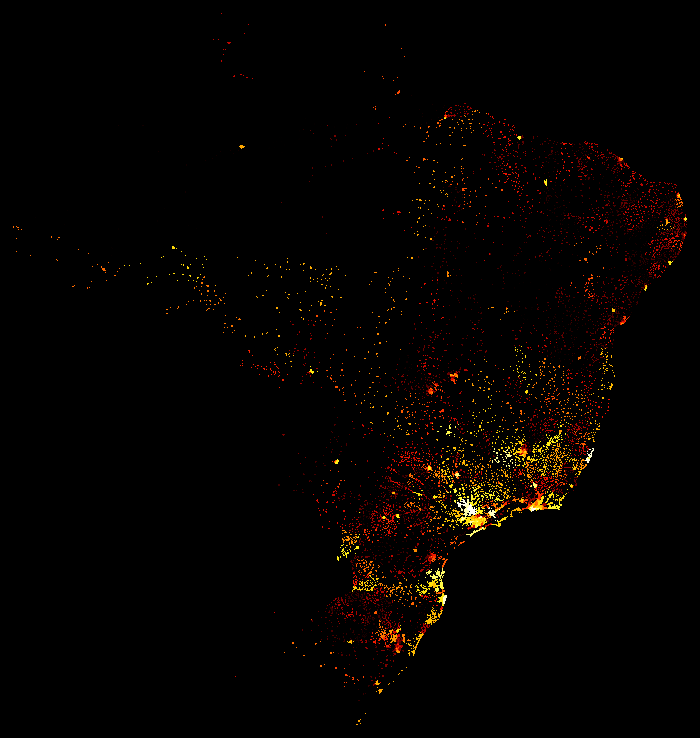

In [70]:
create_map(revenue, fire , ds.mean(agg_name), 'brazil_revenue')

In [71]:
revenue.head()

geolocation_zip_code_prefix  geolocation_lat  geolocation_lng  \
10                         1037       -23.545621       -46.639292   
10                         1046       -23.546081       -46.644820   
10                         1046       -23.546129       -46.642951   
10                         1041       -23.544392       -46.639499   
10                         1035       -23.541578       -46.641607   

   geolocation_city geolocation_state  geolocation_zip_code_prefix_1_digits  \
10        sao paulo                SP                                     0   
10        sao paulo                SP                                     0   
10        sao paulo                SP                                     0   
10        sao paulo                SP                                     0   
10        sao paulo                SP                                     0   

    geolocation_zip_code_prefix_2_digits  \
10                                     1   
10                                     1   
10                                     1   
10                                     1   
10                                     1   

    geolocation_zip_code_prefix_4_digits             x             y  \
10                                   103 -5.191862e+06 -2.698137e+06   
10                                   104 -5.192478e+06 -2.698193e+06   
10                                   104 -5.192270e+06 -2.698199e+06   
10                                   104 -5.191885e+06 -2.697988e+06   
10                                   103 -5.192120e+06 -2.697646e+06   

    payment_value    revenue  
10      6797.4325  6797.4325  
10      6797.4325  6797.4325  
10      6797.4325  6797.4325  
10      6797.4325  6797.4325  
10      6797.4325  6797.4325

In [72]:
# creating a loop that first generates 1 image per month of the year with revenue

#0 work date to contain month and year
orders_map['date'] = pd.to_datetime(orders_map['order_purchase_timestamp'])

orders_map['month'] = pd.DatetimeIndex(orders_map['date']).month
orders_map['year'] = pd.DatetimeIndex(orders_map['date']).year
orders_map['my'] = orders_map['date'].dt.strftime('%Y %B')

#1 data is aggregated on a month basis
df3= pd.read_excel('aux_datecount.xlsx')
test = orders_map.merge(df3, on='my', how= 'left')

#2 now loop through month on month dataframe seleciton

i= 1
df = pd.DataFrame()
for i in range(1,26):
    x = test[test['date_count']== i]
    df = df.append(x)
    df.groupby('customer_zip_code_prefix_3_digits')['payment_value'].sum().to_frame()
    revenue = brazil_geo.join(df)
    agg_name = 'revenue'
    revenue[agg_name] = revenue.payment_value
#3 store the map in the hard drive
    create_map(revenue, fire , ds.mean(agg_name), f'brazil_revenue_{i}')

#4 transform images to GIF using imageio
#### the files should be mobed from 'export' folder to "path" before running the below
images = []
i= 1
for i in range(1,26):
    filename = f'brazil_revenue_{i}.png'
    
    #4.1. read the file as an array using imageio
    
    image = imageio.imread(filename)
    
    #4.2. append the resulting array to a list
    
    images.append(image)
    
#5 save the gif
imageio.mimsave('result.gif', images, fps = 0.75)

In [73]:
orders_map.head()

order_id                       customer_id  \
0  e481f51cbdc54678b7cc49136f2d6af7  9ef432eb6251297304e76186b10a928d   
1  e481f51cbdc54678b7cc49136f2d6af7  9ef432eb6251297304e76186b10a928d   
2  e481f51cbdc54678b7cc49136f2d6af7  9ef432eb6251297304e76186b10a928d   
3  53cdb2fc8bc7dce0b6741e2150273451  b0830fb4747a6c6d20dea0b8c802d7ef   
4  47770eb9100c2d0c44946d9cf07ec65d  41ce2a54c0b03bf3443c3d931a367089   

  order_status order_purchase_timestamp    order_approved_at  \
0    delivered      2017-10-02 10:56:33  2017-10-02 11:07:15   
1    delivered      2017-10-02 10:56:33  2017-10-02 11:07:15   
2    delivered      2017-10-02 10:56:33  2017-10-02 11:07:15   
3    delivered      2018-07-24 20:41:37  2018-07-26 03:24:27   
4    delivered      2018-08-08 08:38:49  2018-08-08 08:55:23   

  order_delivered_carrier_date order_delivered_customer_date  \
0          2017-10-04 19:55:00           2017-10-10 21:25:13   
1          2017-10-04 19:55:00           2017-10-10 21:25:13   
2          2017-10-04 19:55:00           2017-10-10 21:25:13   
3          2018-07-26 14:31:00           2018-08-07 15:27:45   
4          2018-08-08 13:50:00           2018-08-17 18:06:29   

  order_estimated_delivery_date                customer_unique_id  \
0           2017-10-18 00:00:00  7c396fd4830fd04220f754e42b4e5bff   
1           2017-10-18 00:00:00  7c396fd4830fd04220f754e42b4e5bff   
2           2017-10-18 00:00:00  7c396fd4830fd04220f754e42b4e5bff   
3           2018-08-13 00:00:00  af07308b275d755c9edb36a90c618231   
4           2018-09-04 00:00:00  3a653a41f6f9fc3d2a113cf8398680e8   

  customer_zip_code_prefix  ... customer_zip_code_prefix_3_digits  \
0                    03149  ...                                31   
1                    03149  ...                                31   
2                    03149  ...                                31   
3                    47813  ...                               478   
4                    75265  ...                               752   

  payment_sequential  payment_type  payment_installments payment_value  \
0                  1   credit_card                     1        4.5300   
1                  3       voucher                     1        0.5000   
2                  2       voucher                     1        4.6475   
3                  1        boleto                     1       35.3650   
4                  1   credit_card                     3       44.7800   

   value_log                date  month  year            my  
0   1.510722 2017-10-02 10:56:33     10  2017  2017 October  
1  -0.693147 2017-10-02 10:56:33     10  2017  2017 October  
2   1.536329 2017-10-02 10:56:33     10  2017  2017 October  
3   3.565723 2018-07-24 20:41:37      7  2018     2018 July  
4   3.801762 2018-08-08 08:38:49      8  2018   2018 August  

[5 rows x 22 columns]

In [74]:
# group by customer_id when order_status = delivered
clust = orders_map[orders_map['order_status'] == 'delivered']

# calculate total spent, count total orders per customer
clust.groupby('customer_id').agg({'payment_value': ['sum','count']})

payment_value      
                                           sum count
customer_id                                         
00012a2ce6f8dcda20d059ce98491703       28.6850     1
000161a058600d5901f007fab4c27140       16.8525     1
0001fd6190edaaf884bcaf3d49edf079       48.8550     1
0002414f95344307404f0ace7a26f1d5       44.8375     1
000379cdec625522490c315e70c7a9fb       26.7525     1
0004164d20a9e969af783496f3408652       17.9500     1
000419c5494106c306a97b5635748086       12.3500     1
00046a560d407e99b969756e0b10f282       41.6475     1
00050bf6e01e69d5c0fd612f1bcfb69c       21.3075     1
000598caf2ef4117407665ac33275130      313.9275     1
0005aefbb696d34b3424dccd0a0e9fd0       36.8325     1
00062b33cb9f6fe976afdcff967ea74d       14.7375     1
00066ccbe787a588c52bd5ff404590e3       67.5000     1
00072d033fe2e59061ae5c3aff1a2be5       26.7425     1
0009a69b72033b2d0ec8c69fc70ef768       43.4000     1
000bf8121c3412d3057d32371c5d3395       11.3900     1
000e943451fc2788ca6ac98a682f2f49       26.5575     4
000f17e290c26b28549908a04cfe36c1       34.8800     1
000fd45d6fedae68fc6676036610f879       16.7025     1
0010068a73b7c56da5758c3f9e5c7375       13.7075     1
001028b78fd413e19704b3867c369d3a        9.4025     1
00104a47c29da701ce41ee52077587d9       25.0850     1
001051abfcfdbed9f87b4266213a5df1       16.3000     3
00114026c1b7b52ab1773f317ef4880b       16.5025     1
001226b2341ef620415ce7bbafcfac28       11.8825     1
0012a5c13793cf51e253f096a7e740dd       92.4800     1
0013280441d86a4f7a8006efdaf1b0fe       40.5375     1
0013cd8e350a7cc76873441e431dd5ee       23.1500     1
001450ebb4a77efb3d68be5f7887cb1e       15.3325     1
00146ad30454993879adaa91c518f68c       55.4475     1
...                                        ...   ...
ffed5d4f6245fe13cd57054621eec36a       27.0550     1
ffed827348cd4b083956ce2b634b763b       21.9250     1
ffee99041e111172de2006fe9e90202a       25.0125     1
ffef8c44b23871ffd6a1df761bd61783       21.1475     1
fff0f9fbcdf9cfe4d9328bd3a7af71d7       40.4650     1
fff168ca1f8a1d2e8e2108b231a68a8c       17.6900     1
fff1da51c6d3b52986925d7bcd8a6d30        7.6725     1
fff200ad56bd3e1caa576cce9d282672       28.4675     1
fff212062d600f2e1d53f3c5d4a25138       16.3600     1
fff25ab9d3c9ba6ad8119576f285a3d9       55.1775     1
fff39f01a81d96b066b1893ad395a98b        4.3225     1
fff3a5c6d542d52b05f7e4518adf996e       20.8075     3
fff415b4c72e09483a25c15108c65d31       21.1425     1
fff4f0c85a4d710abe06599e1ed08a42       22.4250     1
fff4fdd0de70a51d4e0f57a4c1c6bfae        5.2600     1
fff5169e583fd07fac9fec88962f189d       38.1925     1
fff55ba8dffa552b6fdfd86c2e806459        7.5000     1
fff5dd22d522cf28a902185817642a2e       13.1950     1
fff675a0d5924b9162b4a1bf410466cd       18.7675     1
fff7466a253c0e59499ea943462c10f9       41.5475     1
fff89c8ed4fcf69a823c1d149e429a0b       11.0250     1
fff906ecb75de5809be384e0f8d65e45       25.5325     1
fff93c1da78dafaaa304ff032abc6205       60.6200     1
fffa0238b217e18a8adeeda0669923a3       10.9300     1
fffb97495f78be80e2759335275df2aa       15.2525     1
fffcb937e9dd47a13f05ecb8290f4d3e       22.9775     1
fffecc9f79fd8c764f843e9951b11341       20.3400     3
fffeda5b6d849fbd39689bb92087f431       15.7825     1
ffff42319e9b2d713724ae527742af25       53.5325     1
ffffa3172527f765de70084a7e53aae8       11.3750     1

[96477 rows x 2 columns]

In [75]:
orders_map.shape, reviews.shape

((103886, 22), (100000, 7))

In [76]:
clust = orders_map[orders_map['order_status'] == 'delivered']

In [77]:
clust.shape

(100756, 22)

In [78]:
# X = clust.groupby('customer_id').agg({'payment_value': ['sum','count']})

In [99]:
#making count be x axis and sum be y axis:
X = clust.groupby('customer_id').agg({'payment_value': ['count','sum']})

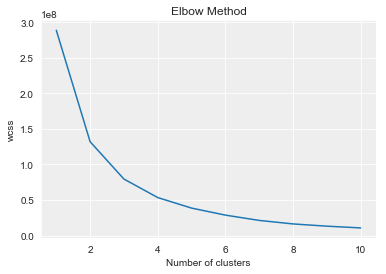

In [100]:
#Using the elbow method to find the optimum number of clusters
from sklearn.cluster import KMeans
wcss = []
for i in range(1,11):
    km=KMeans(n_clusters=i,init='k-means++', max_iter=300, n_init=10, random_state=0)
    km.fit(X)
    wcss.append(km.inertia_)
plt.plot(range(1,11),wcss)
plt.title('Elbow Method')
plt.xlabel('Number of clusters')
plt.ylabel('wcss')
plt.show()

In [104]:
##Fitting kmeans to the dataset with k=4
km4=KMeans(n_clusters=4,init='k-means++', max_iter=300, n_init=10, random_state=0)
y_means = km4.fit_predict(X)


In [81]:
y_means

array([0, 0, 3, ..., 0, 3, 0])

In [113]:
data = X.values

In [83]:
X.head(1)

payment_value      
                                           sum count
customer_id                                         
00012a2ce6f8dcda20d059ce98491703        28.685     1

In [114]:
y = data[:,1]
x = data[:,0]

Text(0, 0.5, 'Total spent in purchases')

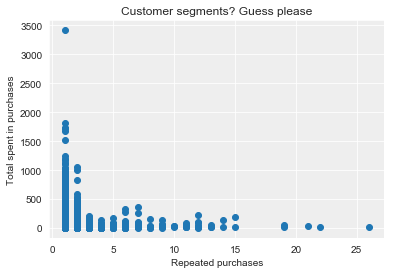

In [117]:
plt.scatter(x,y)
plt.title('Customer segments? Guess please')
plt.xlabel('Repeated purchases')
plt.ylabel('Total spent in purchases')

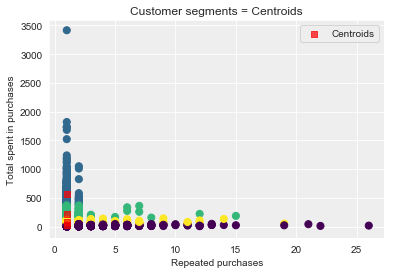

In [116]:
plt.scatter(x, y, c=y_means, s=50, cmap='viridis')
plt.scatter(km4.cluster_centers_[:,0], km4.cluster_centers_[:,1],s=30,marker='s', c='red', alpha=0.7, label='Centroids')
plt.title('Customer segments = Centroids')
plt.xlabel('Repeated purchases')
plt.ylabel('Total spent in purchases')
plt.legend()
